In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 5.2 MB/s eta 0:00:00


In [2]:
import requests
from bs4 import BeautifulSoup
import os
from google.colab import drive
import json
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error, mean_absolute_percentage_error


warnings.filterwarnings("ignore")

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def plot_ts(time_data,plot_data,title_ts=""): # plot 1 time series
  fig, ax = plt.subplots(figsize=(20, 5))

  # Plot the data
  ax.plot(time_data,plot_data)

  # Set the primary x-axis for months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

  # Add the secondary x-axis for years in the middle of the year
  sec_ax = ax.secondary_xaxis("bottom")
  sec_ax.xaxis.set_major_locator(mdates.YearLocator())
  sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  sec_ax.tick_params(axis='x', which='major', pad=20)

  # Labeling and title
  ax.set_ylabel('Number of Rides')
  ax.set_title(title_ts)
  sec_ax.set_xlabel('Time')

  # Display the grid and the plot
  ax.grid(True)
  plt.show()

def compare_ts(time_data, series1, series2, label1, label2, title_ts="", same_scale=False):
    fig, ax1 = plt.subplots(figsize=(20, 5))

    # Plot series1 on the left y-axis
    line1, = ax1.plot(time_data, series1, color='blue', label=label1)
    ax1.set_ylabel(label1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Set the primary x-axis for months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

    # Add the secondary x-axis for years
    sec_ax = ax1.secondary_xaxis("bottom")
    sec_ax.xaxis.set_major_locator(mdates.YearLocator())
    sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    sec_ax.tick_params(axis='x', which='major', pad=20)
    sec_ax.set_xlabel('Time')

    # Create a twin axis for the right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(time_data, series2, color='orange', label=label2)
    ax2.set_ylabel(label2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Set the same y-axis scale if same_scale is True
    if same_scale:
        min_val = min(series1.min(), series2.min())
        max_val = max(series1.max(), series2.max())
        ax1.set_ylim(min_val, max_val)
        ax2.set_ylim(min_val, max_val)

    # Set title and grid
    ax1.set_title(title_ts)
    ax1.grid(True)

    # Combine legends for both plots
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")

    # Adjust layout
    fig.tight_layout()
    plt.show()

def error_metrics(real, pred): # Compare predictions and real values
  mae = mean_absolute_error(real, pred)
  mse = mean_squared_error(real, pred)
  mape = mean_absolute_percentage_error(real, pred)
  smape = mean_absolute_percentage_error(real, pred, symmetric=True)
  r2 = r2_score(real, pred)  # Calculate R-squared

  # Print results
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Mean Squared Error (MSE): {mse:.2f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")
  print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape*100:.2f}%")
  print(f"R-squared (R²): {r2:.4f}")  # Display R-squared

In [6]:
data_raw = pd.read_parquet("/content/drive/Shared drives/Time Series/divvy_data/prod/station/divvy_data_expanded.parquet")
print(data_raw.shape)
data_raw.head(4)

(21846092, 12)


,rideable_type,date,start_station_name,end_station_name,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,rides
0,classic_bike,2020-12-02,900 W Harrison St,Wolcott Ave & Polk St,13028,TA1309000064,41.874754,-87.649807,41.871262,-87.673688,member,1
1,classic_bike,2020-12-02,Aberdeen St & Jackson Blvd,Clinton St & Roosevelt Rd,13157,WL-008,41.877726,-87.654787,41.867118,-87.641088,member,1
2,classic_bike,2020-12-02,Albany Ave & Montrose Ave,Kedzie Ave & Milwaukee Ave,15621,13085,41.961041,-87.705866,41.929567,-87.707857,member,1
3,classic_bike,2020-12-02,Ashland Ave & 13th St,Blue Island Ave & 18th St,13354,13135,41.865234,-87.666507,41.857556,-87.661535,member,1


In [46]:
daily_traffic = data_raw.groupby(['start_station_name','end_station_name','date'])['rides'].sum().reset_index()
flow_out_traffic = daily_traffic.groupby(['start_station_name','date'])['rides'].sum().reset_index()
flow_in_traffic = daily_traffic.groupby(['end_station_name','date'])['rides'].sum().reset_index()
daily_station_traffic = pd.merge(flow_out_traffic,flow_in_traffic,
                  how="outer",
                  left_on=["start_station_name","date"],right_on=["end_station_name","date"],
                  suffixes=("_flow_out", "_flow_in"))
daily_station_traffic["end_station_name"].fillna(daily_station_traffic["start_station_name"],inplace=True)
daily_station_traffic.drop(columns=["start_station_name"],inplace=True)
daily_station_traffic.rename(columns={"end_station_name":"station_name"},inplace=True)
daily_station_traffic.fillna(0,inplace=True)
daily_station_traffic["changes"]=daily_station_traffic["rides_flow_in"]-daily_station_traffic["rides_flow_out"]
daily_station_traffic["bikes"]=daily_station_traffic["changes"].cumsum()
daily_station_traffic.head()

,date,rides_flow_out,station_name,rides_flow_in,changes,bikes
0,2022-07-20,0.0,10101 S Stony Island Ave,2.0,2.0,2.0
1,2022-08-13,1.0,10101 S Stony Island Ave,0.0,-1.0,1.0
2,2022-08-15,0.0,10101 S Stony Island Ave,1.0,1.0,2.0
3,2022-08-16,1.0,10101 S Stony Island Ave,0.0,-1.0,1.0
4,2022-08-21,0.0,10101 S Stony Island Ave,1.0,1.0,2.0


In [52]:
daily_station_traffic.groupby(["station_name"])["bikes"].sum().sort_values(ascending=False)

,bikes
station_name,
Paulina St & 18th St,73031756.0
Paulina St & Flournoy St,72390558.0
Paulina Ave & North Ave,71710173.0
Paulina St & Howard St,70722803.0
Paulina St & Montrose Ave,69766417.0
...,...
Ogden Ave & Race Ave,-216410331.0
Orleans St & Chestnut St (NEXT Apts),-218156446.0
Orleans St & Elm St,-221733146.0


Text(0.5, 1.0, 'nbr of bikes in Streeter Dr & Grand Ave')

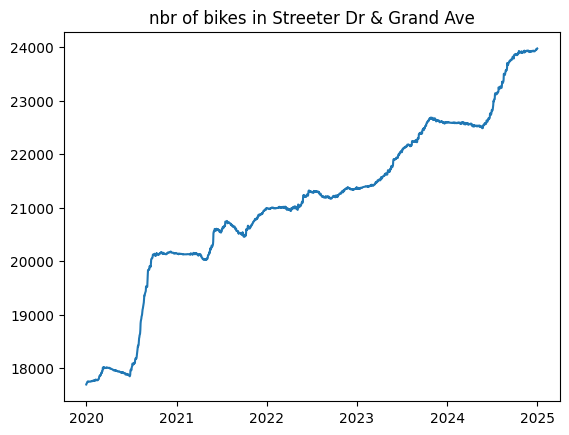

In [56]:
target = daily_station_traffic[daily_station_traffic["station_name"]=="Streeter Dr & Grand Ave"]
plt.plot(target["date"],target["bikes"])
plt.title("nbr of bikes in Streeter Dr & Grand Ave")

In [42]:
target[target["bikes"]>100]

,date,rides_flow_out,station_name,rides_flow_in,bikes
1039147,2020-08-08,659.0,Streeter Dr & Grand Ave,779.0,120.0
1039175,2020-09-05,758.0,Streeter Dr & Grand Ave,893.0,135.0
1039438,2021-05-30,958.0,Streeter Dr & Grand Ave,1111.0,153.0
1040609,2024-08-18,355.0,Streeter Dr & Grand Ave,471.0,116.0


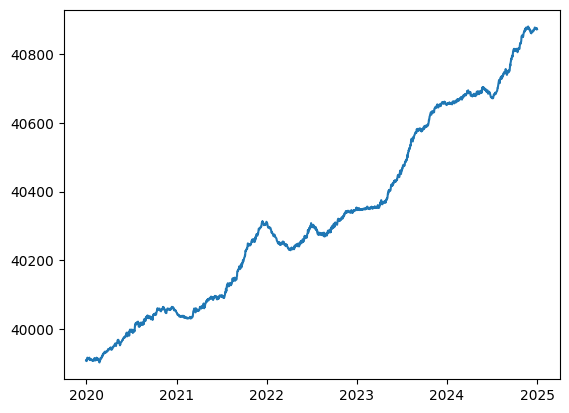

In [54]:
target = daily_station_traffic[daily_station_traffic["station_name"]=="Paulina St & 18th St"]
plt.plot(target["date"],target["bikes"])
plt.title("nbr of bikes in Paulina St & 18th St")